# Exploring API Umbrella Elasticsearch analytics
This notebook shows some basic techniques to explore analytics data from an API Umbrella Elasticsearch instance.

## Imports
This notebook relies on several libraries. They are imported, and configured where possible, below.

In [33]:
import os
from pprint import pprint

# Data import
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search

# Data analysis/exploration
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(17,7))

import seaborn as sns
sns.set(style="white", color_codes=True)

%matplotlib inline

## Elasticsearch initialization and query
The data for this notebook originates from an Elasticsearch server. The following code initializes the Elasticsearch client and requests the analytics data.

In [35]:
# Get Elasticsearch URL from environment variable
elasticsearch_url = os.environ['ELASTICSEARCH_URL']

# Create Elasticsearch client
client = Elasticsearch([elasticsearch_url])

# Make sure client can connect to Elasticsearch instance
client.info()

{'cluster_name': 'api-umbrella',
 'name': 'Invisible Woman',
 'status': 200,
 'tagline': 'You Know, for Search',
 'version': {'build_hash': '00f95f4ffca6de89d68b7ccaf80d148f1f70e4d4',
  'build_snapshot': False,
  'build_timestamp': '2016-02-02T09:55:30Z',
  'lucene_version': '4.10.4',
  'number': '1.7.5'}}

In [54]:
# Create Elasticsearch search instance
search = Search(using=client)

# Get the total number of results
total = search.count()

# Update the search instance to contain all results
search = search[0:total]

# Execute the search
results = search.execute()

## Pandas DataFrame
In order to explore the data, we want to load it into a Pandas DataFrame.

In [55]:
# Convert the search results to a Pandas DataFrame
results_df = json_normalize(results.hits.hits)

# List dataframe columns
for column in results_df.columns:
    print(column)

_id
_index
_score
_source.api_key
_source.backend_response_time
_source.gatekeeper_denied_code
_source.internal_gatekeeper_time
_source.proxy_overhead
_source.request_accept
_source.request_accept_encoding
_source.request_at
_source.request_basic_auth_username
_source.request_connection
_source.request_content_type
_source.request_hierarchy
_source.request_host
_source.request_ip
_source.request_ip_city
_source.request_ip_country
_source.request_ip_location
_source.request_ip_location.lat
_source.request_ip_location.lon
_source.request_ip_region
_source.request_method
_source.request_origin
_source.request_path
_source.request_query
_source.request_query.#33;
_source.request_query._
_source.request_query.age-group
_source.request_query.api-key
_source.request_query.api_key
_source.request_query.author
_source.request_query.beta_analytics
_source.request_query.brand
_source.request_query.c
_source.request_query.client_id
_source.request_query.code
_source.request_query.columns[0][data]


In [56]:
# Count number of results containing value for each column
results_count_sorted = results_df.count().sort_values(ascending=False).iteritems()

# Print each metric and value
for key, value in results_count_sorted:
    print(key, value)

_type 9895
_source.request_url 9895
_index 9895
_score 9895
_source.request_at 9895
_source.request_hierarchy 9895
_source.request_host 9895
_source.request_ip 9895
_source.request_method 9895
_source.request_path 9895
_source.request_scheme 9895
_source.request_size 9895
_id 9895
_source.response_status 9895
_source.response_size 9895
_source.response_time 9895
_source.internal_gatekeeper_time 9887
_source.proxy_overhead 9887
_source.response_cache 9866
_source.request_connection 9823
_source.response_server 9672
_source.request_accept 9637
_source.response_content_type 9600
_source.request_ip_location.lon 9322
_source.request_ip_country 9322
_source.request_ip_location.lat 9322
_source.request_ip_region 7447
_source.request_ip_city 7417
_source.backend_response_time 6164
_source.request_user_agent 6116
_source.response_age 5989
_source.request_accept_encoding 5984
_source.api_key 5859
_source.user_registration_source 5835
_source.user_email 5835
_source.user_id 5835
_source.request_u

In [57]:
# Add request_date column by converting request_at column to datetime
results_df['request_date'] = pd.to_datetime(results_df['_source.request_at'], unit='ms')

In [58]:
# Use request_date for dataframe index
results_df.set_index('request_date', inplace=True)

In [59]:
response_status_only_df = results_df['_source.response_status']
response_status_only_df
response_status_only_df.to_csv('http_response_status_data.csv', header=['response_code'])

## Derived column(s)
We may want to compute some values, based on existing columns. For example, determining whether requests are successful or failure, based on status code.

### Is success?
Check whether the request was successful by looking at status code. Divide the data into two groups 'success' and 'failure', where success is any response with a 2xx status code and failure is any other response.

In [60]:
def is_success_function(row):
    """
    Check if row (request) was successful
    Successful means a response with 2xx status
    
    return True if successful False otherwise
    """
    success = (row['_source.response_status'] >= 200 and row['_source.response_status'] < 300)
    
    if success:
        return 'Success'
    else:
        return 'Failure'

In [61]:
# Add 'Success' column to API Logs
# Success is determined by status code, where any status in the 200s is considered successful
results_df['Outcome'] = results_df.apply(is_success_function, axis='columns')

### Response status class
Divide the data into four groups, based on response status:

- 2xx: 'success'
- 3xx: 'warning'
- 4xx: 'client_error'
- 5xx: 'server_error'

In [62]:
def determine_response_class(row):
    """
    Check the status code of a given row, and return a response class.
    
    - 2xx: 'success'
    - 3xx: 'warning'
    - 4xx: 'client_error'
    - 5xx: 'server_error'
    - NaN or 0: 'unknown'
    """
    
    response_status = row['_source.response_status']
    
    if response_status >= 200 and response_status < 300:
        return 'success'
    elif response_status >= 300 and response_status < 400:
        return 'warning'
    elif response_status >= 400 and response_status < 500:
        return 'client_error'
    elif response_status >= 500 and response_status < 600:
        return 'server_error'
    else:
        return 'unknown'

In [63]:
# Add 'Response class' column to API Logs, where response class is determined by HTTP status code
results_df['Response class'] = results_df.apply(determine_response_class, axis='columns')

# Visualize

## Status codes
Status code indicates whether request was, more or less, successful or failure.

In [64]:
# Count response status codes
status_code_value_counts = results_df['_source.response_status'].value_counts()

status_code_value_counts

200    3816
201    2499
404    1209
204     823
302     693
304     266
403     196
422     111
500      97
301      88
499      29
401      23
502      18
406      11
504      11
405       3
411       2
Name: _source.response_status, dtype: int64

In [65]:
# Color map for response classes
responseClassPalette = {
        'success': 'green',
        'warning': 'yellow',
        'client_error': 'orange',
        'server_error': 'red',
    }

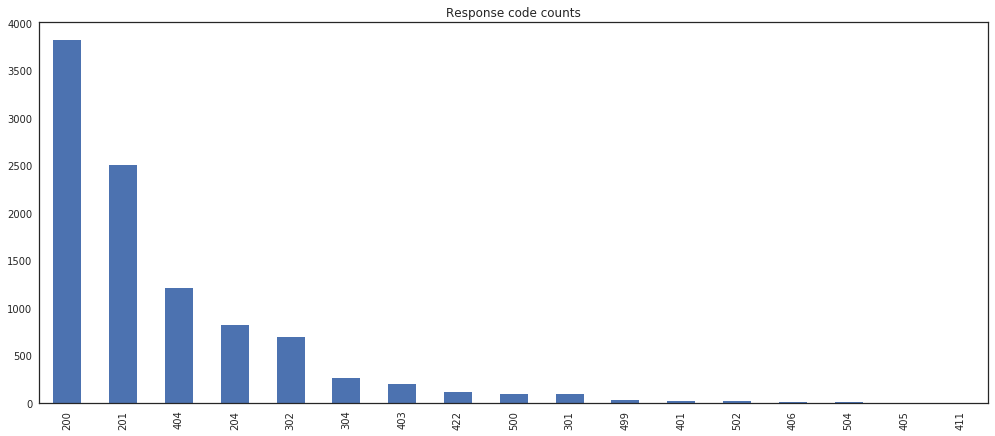

In [66]:
# Sorted distribution of statuses in the data
api_response_code_distributions_plot = status_code_value_counts.plot('bar', title='Response code counts', figsize=(17, 7))

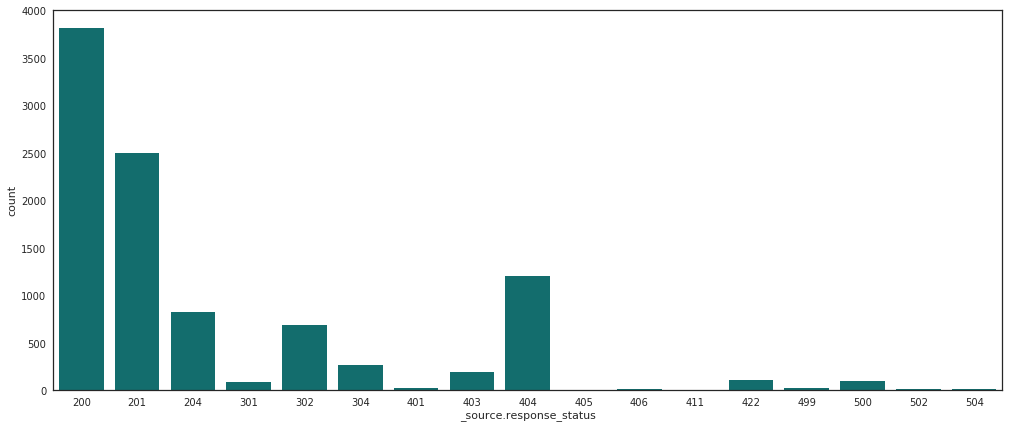

In [67]:
# Make the plot wider and taller
plt.figure(figsize=(17,7))

# Use seaborn to produce a countplot of response status codes
status_code_counts_plot = sns.countplot(
    x='_source.response_status',
    data=results_df,
    color='teal',
    saturation=0.7)

/home/brylie/anaconda3/envs/apinf-elasticsearch/lib/python3.5/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


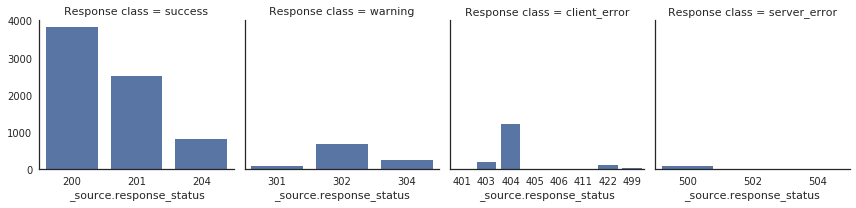

In [79]:
grid = sns.FacetGrid(results_df, col='Response class', sharex=False)

grid.map(sns.countplot, '_source.response_status')

## Success or failure
Show the proportion of calls that are successful (2xx) or failure (3xx, 4xx, 5xx).

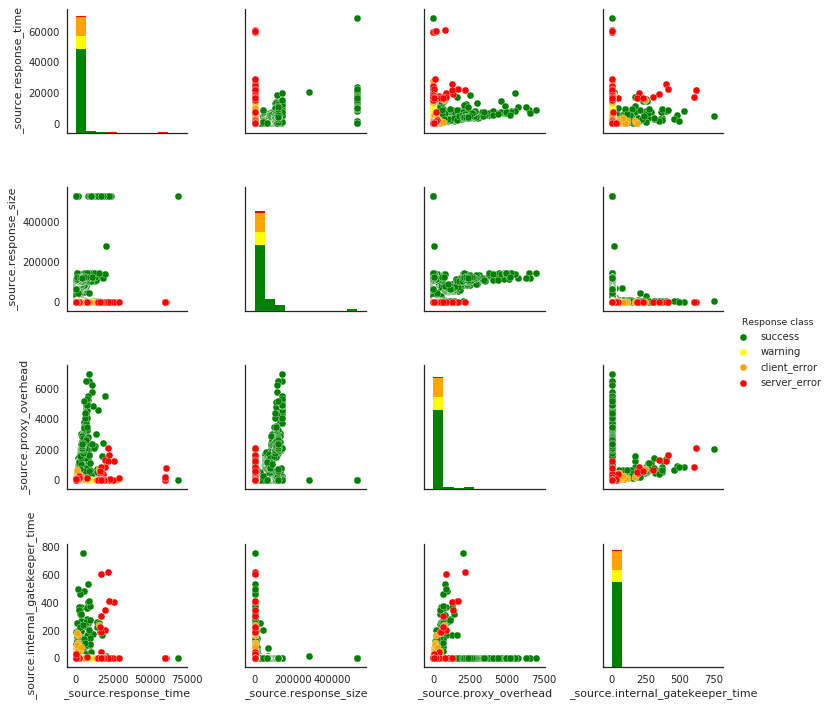

In [70]:
success_failure_pairplot = sns.pairplot(
    results_df,
    vars=[
        '_source.response_time',
        '_source.response_size',
        '_source.proxy_overhead',
        '_source.internal_gatekeeper_time',
    ],
    hue='Response class',
    palette=responseClassPalette
)

## Proxy overhead
Proxy overhead is a measurement of how much latency the proxy adds to a request.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3454b7f0b8>]], dtype=object)

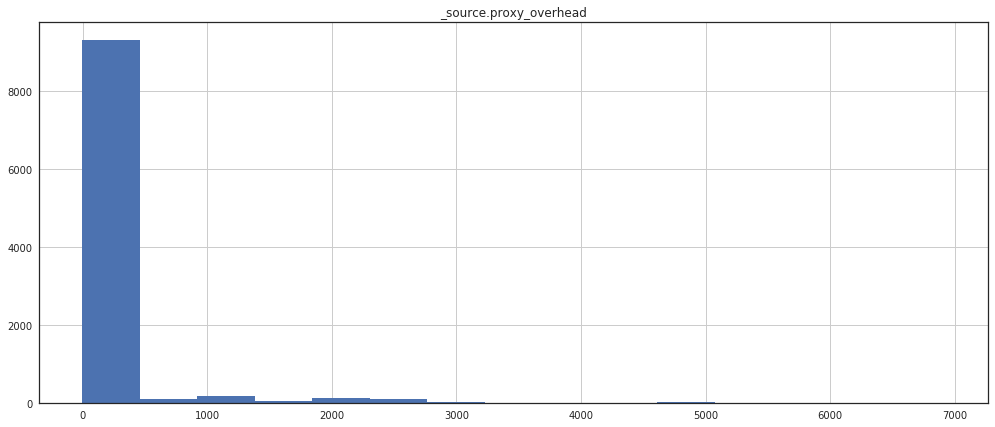

In [71]:
pd.DataFrame.hist(results_df, column='_source.proxy_overhead', bins=15, figsize=(17, 7))

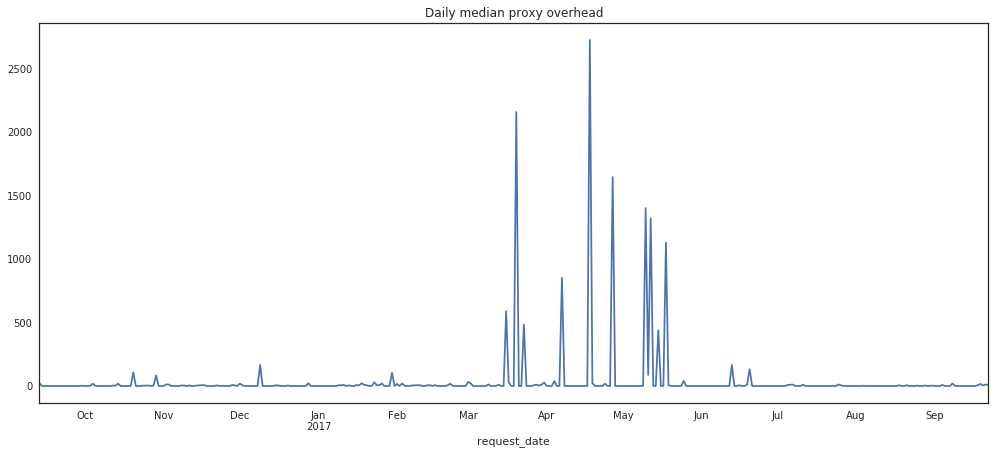

In [72]:
# Calculate the daily median proxy overhead
daily_median_proxy_overhead = results_df['_source.proxy_overhead'].resample('D').median()

# Fill empty values with zero
daily_median_proxy_overhead_filled = daily_median_proxy_overhead.fillna(0)

# Plot chart and save as variable
daily_median_proxy_overhead_chart = daily_median_proxy_overhead_filled.plot(
    figsize=(17, 7),
    title='Daily median proxy overhead')

# Analysis
Look for patterns and correlations in the data.

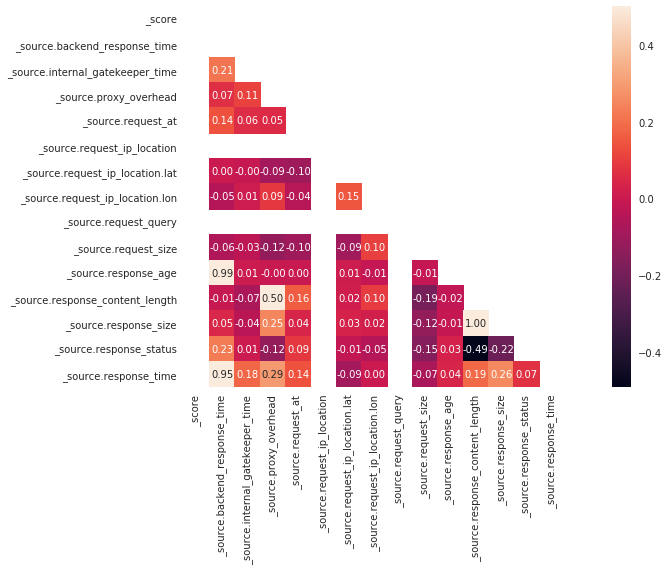

In [73]:
# Find correlation between columns in the analytics DataFrame
correlation_matrix = results_df.corr()

# Create mask for upper right half of heatmap
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Make the plot wider and taller
plt.figure(figsize=(17,7))

# Show correlations as a heatmap with white background
correlation_heatmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', mask=mask, square=True, vmax=.5)

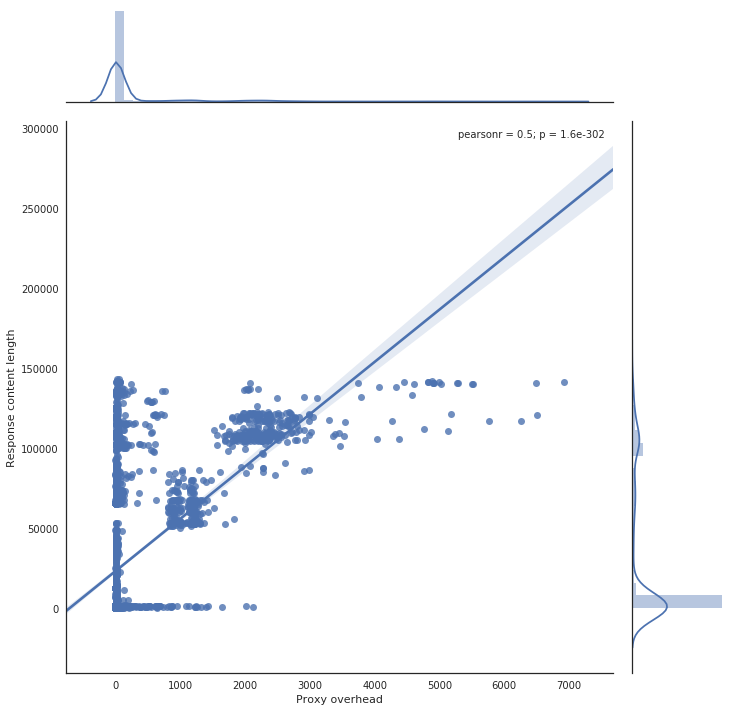

In [74]:
# Show relationship proxy overhead and response content length
proxy_overhead_response_content_length_plot = sns.jointplot(
    data=results_df,
    x='_source.proxy_overhead',
    y='_source.response_content_length',
    kind="reg",
    size=10,
).set_axis_labels("Proxy overhead", "Response content length")

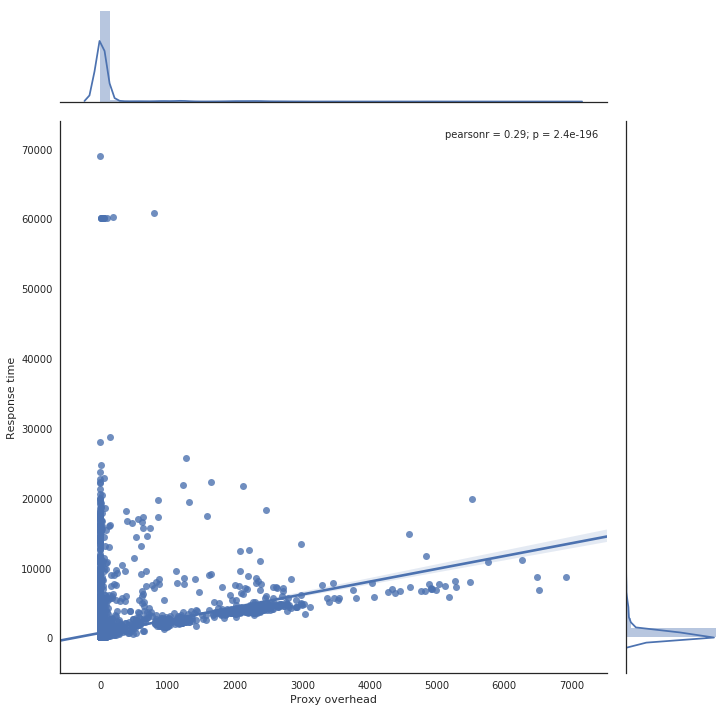

In [75]:
# Show relationship between proxy overhead and response time
proxy_overhead_response_time_plot = sns.jointplot(
    data=results_df,
    x='_source.proxy_overhead',
    y='_source.response_time',
    kind="reg",
    size=10,
).set_axis_labels("Proxy overhead", "Response time")